In [436]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, json
import datetime
import re
from unidecode import unidecode
from pylab import rcParams
import string
import nltk
from nltk.corpus import stopwords

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Cleaning

In [551]:
def format_date(date):
    day, month, year = date.split("-")
    return datetime.datetime(int(year), int(month), int(day)).strftime("%Y-%m-%d")
                                  
def speeches_from_json(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    return [{
        #"report_id": json_file.split("\\")[-1], 
        "section": data["section"], 
        "date": format_date(data["date"]),
        "title": data["title"],
        "name": speech["name"] or np.nan,
        "speech": speech["speech"] or np.nan,
    } for speech in data["speeches"]]

First, load all json files

In [529]:
DIR = ".\\parliament"

In [530]:
speeches = [speech for parliament_number in os.listdir(DIR) if not parliament_number.endswith(".csv")
                   for f in os.listdir(f"{DIR}\\{parliament_number}") if f.lower().endswith(".json") 
                   for speech in speeches_from_json(f"{DIR}\\{parliament_number}\\{f}")]

Create a data frame

In [537]:
df = pd.DataFrame.from_records(speeches)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177356 entries, 0 to 177355
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   section  177356 non-null  object
 1   date     177356 non-null  object
 2   title    177356 non-null  object
 3   name     173695 non-null  object
 4   speech   177354 non-null  object
dtypes: object(5)
memory usage: 6.8+ MB


In [539]:
df.head()

,section,date,title,name,speech
0,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,The Prime Minister:,"Mr Speaker, Sir, I have His Excellency the Yan..."
1,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,Mr Speaker:,"Second Reading, what day?"
2,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,The Prime Minister:,"22nd of December, 1965."
3,BILLS,1965-12-14,SINGAPORE TELEPHONE BOARD (AMENDMENT) BILL,NaN,"""to amend the Singapore Telephone Board Ordina..."
4,BILLS,1965-12-15,PEOPLE'S DEFENCE FORCE BILL,The Minister of Defence (Dr Goh Keng Swee):,"Mr Speaker, Sir, I have the recommendation of ..."


### Remove rows with empty speech and name

In [540]:
df = df.dropna()
df.shape

(173694, 5)

### Normalize case

In [545]:
def normalize_case(text):
    return text.lower()

In [546]:
df['section'] = df['section'].map(normalize_case)
df['title'] = df['title'].map(normalize_case)
df['name'] = df['name'].map(normalize_case)
df['speech'] = df['speech'].map(normalize_case)

### Remove Punctuations

In [547]:
def remove_punctuations(text):
    return re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

In [548]:
df['title'] = df['title'].map(remove_punctuations)
df['name'] = df['name'].map(remove_punctuations)
df['speech'] = df['speech'].map(remove_punctuations)

### Remove stopwords

In [552]:
def remove_stopwords(text):
    stop = stopwords.words('english')
    return " ".join([word for word in text.split() if word not in (stop)])

In [569]:
df['speech'] = df['speech'].map(remove_stopwords)

In [570]:
df.head()

,section,date,title,name,speech
0,bills,1965-12-13,constitution amendment bill,lee kuan yew,mr speaker sir excellency yang dipertuan negar...
2,bills,1965-12-13,constitution amendment bill,lee kuan yew,22nd december 1965
4,bills,1965-12-15,peoples defence force bill,goh keng swee,mr speaker sir recommendation excellency yang ...
6,bills,1965-12-15,peoples defence force bill,goh keng swee,first available sitting day 23rd december 1965
8,motions,1965-12-16,adjournment motion business motion,e. w. barker,mr speaker sir permission general assent house...


### Map MPs' names

How many MPs in the data frame?

In [560]:
df['name'].unique().shape

(422,)

How many actual MPs ?

In [555]:
with open(f"{DIR}\\mp.csv") as f:
    # remove newline, lowercase all characters, remove all characters that are NOT alphabet or dot
    mp = [re.sub(r"[^a-z. ]", "", line.replace("\n","").lower().strip()) for line in f.readlines() if line.strip()]
    # "[a-z]." -> "[a-z]. "
    mp = [re.sub(r"[a-z]\.", lambda m: m.group() + " ", name).replace("  ", " ") for name in mp]
    print("Number of actual MPs:", len(mp))

Number of actual MPs: 627


The number of MPs in the dataframe is greater than the actual number. Let's correct this.

In [563]:
def extract_name(s, samples):
    def append_dot_if_single(w):
        if len(w) == 1:
            return w + "."
        return w
    name = " ".join([append_dot_if_single(w) for w in s.split()])
    for sample in samples:
        if sample in name:
            return sample.strip()
    if 'prime minister' in name: # many reports use prime minister instead of his name
        return 'lee kuan yew'
    return np.nan
df['name'] = df['name'].map(lambda c: extract_name(c, mp))

In [565]:
df = df.dropna()
df['name'].unique().shape

(421,)

then convert it to categorical data

In [566]:
df["name"] = df["name"].astype("category")
df.shape

(123780, 5)

### Merge similar sections

How many types of sections?

In [510]:
df['section'].unique()

array(['bills', 'motions', 'oral answers questions',
       'ministerial statement', 'budget', 'personal explanation',
       'oral answer question', 'election president', 'speaker',
       'matter raised adjournment motion', 'written answers questions',
       "president's address", 'tributes',
       'oral answers questions reached', 'oral answer question reached',
       'petitions', 'second reading bills', 'clarification',
       'written answer question', 'ministerial statements',
       'written answers questions oral answer answered 3.00 pm',
       'written answer question oral answer answered 3.00 pm',
       'written answers questions oral answer answered 5.00 pm',
       'bills introduced',
       'written answers questions oral answer answered end question time',
       'correction written statement', 'attendance',
       'oral answers question', 'motion'], dtype=object)

Merge all "..answer to question.." into "answers to questions"

In [567]:
df['section'] = df['section'].map(lambda c: 'answers to questions' if re.search(r"answer(s?) to question(s?)", c) else c)

Merge all "..motion.." into "motions"

In [568]:
df['section'] = df['section'].map(lambda c: 'motions' if re.search(r"motion(s?)", c) else c)

Merge "bills" and "second reading bills" into "bills"

In [ ]:
df['section'] = df['section'].map(lambda c: 'bills' if re.search(r"bill(s?)", c) else c)

Convert it to categorical data

In [512]:
df["section"] = df["section"].astype("category")

Convert column 'date' to datetime type

In [513]:
df['date'] = pd.to_datetime(df['date'])

Sort the data frame by descending date

In [527]:
df = df.sort_values('date', ascending=False).reset_index(drop=True)
df.head()

,report_id,section,date,title,name,speech,speech_length_characters,speech_length_words
0,oral-answer-2675.json,oral answers questions,2022-01-12,"proposal redacted version banned book ""red lin...",sitoh yih pin,asked minister communications information aris...,228,25
1,written-answer-na-9569.json,written answers questions oral answer answered...,2022-01-12,"proposal ban ""onlyfans"" website due distributi...",shahira abdullah,asked minister communications information whet...,125,14
2,motion-1790.json,motions,2022-01-12,towards low-carbon society,hany soh,last year's motion accelerate efforts address ...,6226,751
3,oral-answer-2674.json,oral answers questions,2022-01-12,"steps programmes identify, groom develop promi...",xie yao quan,"asked minister culture, community youth (a) go...",261,33
4,bill-565.json,second reading bills,2022-01-12,legal profession (amendment) bill,raj joshua thomas,"sir, declare interest practising litigation la...",5575,710


# Text statistics

Calculate length of speech in terms of characters and words

In [517]:
stat_df = df.copy()
stat_df['speech_length_characters'] = stat_df['speech'].str.len()
stat_df['speech_length_words'] = stat_df['speech'].str.split().map(lambda x: len(x))
stat_df.head()

,report_id,section,date,title,name,speech,speech_length_characters,speech_length_words
0,oral-answer-2675.json,oral answers questions,2022-01-12,"proposal redacted version banned book ""red lin...",sitoh yih pin,asked minister communications information aris...,228,25
1,oral-answer-2676.json,oral answers questions,2022-01-12,"considerations classifying ""red lines: politic...",josephine teo,"mr speaker, thank ms tin supplementary questio...",265,31
2,written-answer-9699.json,written answers questions,2022-01-12,revisions design technology on-board units nex...,yip hon weng,asked minister transport (a) revisions design ...,240,29
3,bill-565.json,second reading bills,2022-01-12,legal profession (amendment) bill,christopher de souza,efforts yielded results. singapore recognised ...,15760,1946
4,written-answer-9696.json,written answers questions,2022-01-12,closure cpf account discontinuation cpf life p...,dennis tan lip fong,asked minister manpower (a) whether singaporea...,341,44


Distribution of the number of characters

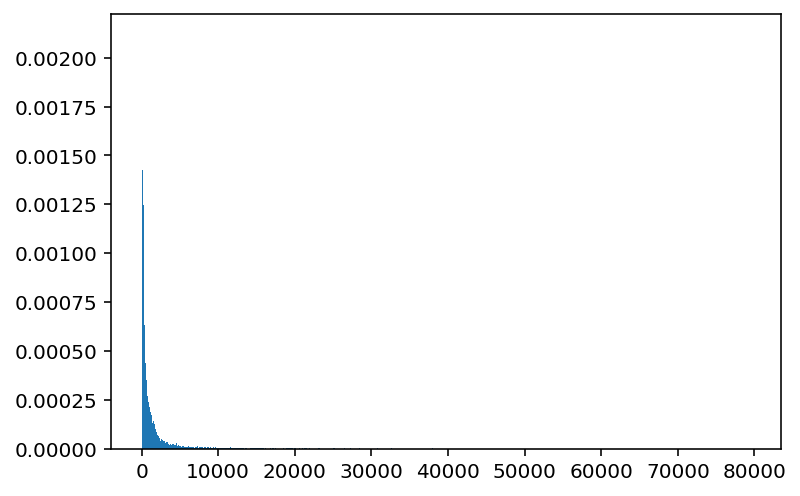

In [518]:
bins = np.arange(0,stat_df['speech_length_characters'].max(),10)
plt.hist(stat_df['speech_length_characters'], bins=bins, density=True)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

Distribution of the number of words

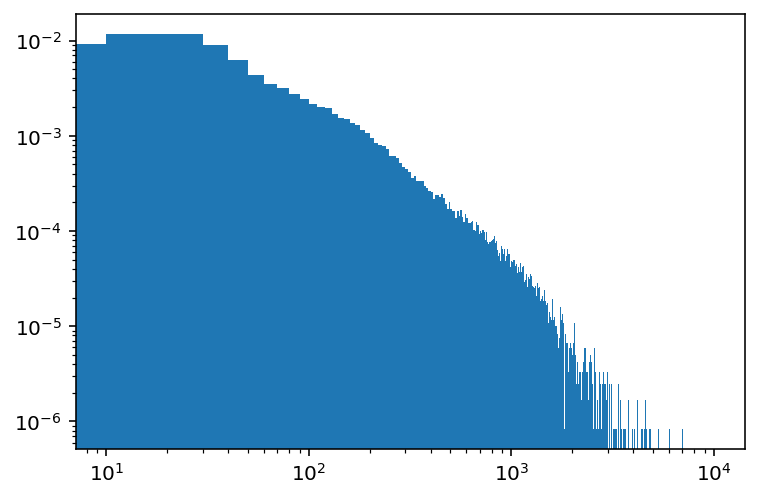

In [519]:
bins = np.arange(0,stat_df['speech_length_words'].max(),10)
plt.hist(stat_df['speech_length_words'], bins=bins, density=True)
plt.xscale('log')
plt.yscale('log')
plt.show()

Number of speeches per MP

In [520]:
speech_dist = stat_df[['name','speech', 'speech_length_words', 'speech_length_characters']].groupby(['name']).agg({
    "speech": ["count"], 
    "speech_length_words": ["max", "min", "mean", "median", "std"], 
    "speech_length_characters": ["max", "min", "mean", "median", "std"]})
speech_dist = speech_dist.sort_values([('speech','count')], ascending=False).reset_index()
speech_dist

name speech speech_length_words                          \
                       count                 max  min        mean median   
0      chiam see tong   4219                2079    1   58.280398   16.0   
1     low thia khiang   2462                1390    1   68.902924   24.0   
2         ng kah ting   1792                1844    1   72.892857   28.0   
3        gan kim yong   1644                3489    1  184.951946  123.0   
4       khaw boon wan   1640                3759    1  140.114634   78.0   
..                ...    ...                 ...  ...         ...    ...   
407         koo young      2                 104   21   62.500000   62.5   
408         s iswaran      2                 228  129  178.500000  178.5   
409      poh ber liak      2                 366   56  211.000000  211.0   
410  c. v. devan nair      1                 502  502  502.000000  502.0   
411      lee teck him      1                   2    2    2.000000    2.0   

                speech_length_characters                             \
            std                      max   min         mean  median   
0    132.246020                    16055     2   430.866082   118.0   
1    139.110587                    10486     3   530.975630   178.0   
2    155.408626                    14069     3   547.219866   209.0   
3    295.745936                    27278     5  1473.583942   987.0   
4    290.397899                    28420     3  1070.694512   604.0   
..          ...                      ...   ...          ...     ...   
407   58.689863                      777   168   472.500000   472.5   
408   70.003571                     1917  1064  1490.500000  1490.5   
409  219.203102                     2861   398  1629.500000  1629.5   
410         NaN                     3930  3930  3930.000000  3930.0   
411         NaN                        8     8     8.000000     8.0   

                  
             std  
0     988.653139  
1    1080.868366  
2    1186.092203  
3    2320.570433  
4    2183.131282  
..           ...  
407   430.628030  
408   603.162084  
409  1741.604002  
410          NaN  
411          NaN  

[412 rows x 12 columns]

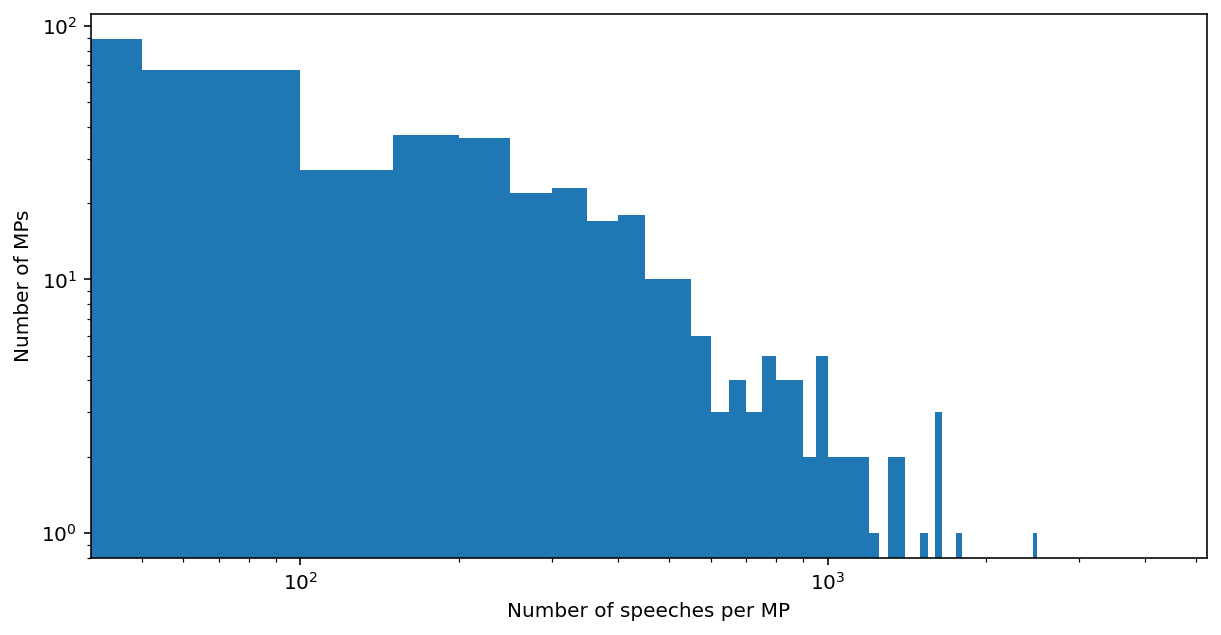

In [521]:
rcParams['figure.figsize'] = 10, 5 
bins = np.arange(0, max(speech_dist[('speech','count')]), 50)
plt.hist(speech_dist[('speech','count')], bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of speeches per MP")
plt.ylabel("Number of MPs")
plt.show()

# 14th parliament

In [523]:
parliament14_df = df[df['date'] >= '2020-08-24']
parliament14_df

,report_id,section,date,title,name,speech,speech_length_characters,speech_length_words
0,oral-answer-2675.json,oral answers questions,2022-01-12,"proposal redacted version banned book ""red lin...",sitoh yih pin,asked minister communications information aris...,228,25
1,oral-answer-2676.json,oral answers questions,2022-01-12,"considerations classifying ""red lines: politic...",josephine teo,"mr speaker, thank ms tin supplementary questio...",265,31
2,written-answer-9699.json,written answers questions,2022-01-12,revisions design technology on-board units nex...,yip hon weng,asked minister transport (a) revisions design ...,240,29
3,bill-565.json,second reading bills,2022-01-12,legal profession (amendment) bill,christopher de souza,efforts yielded results. singapore recognised ...,15760,1946
4,written-answer-9696.json,written answers questions,2022-01-12,closure cpf account discontinuation cpf life p...,dennis tan lip fong,asked minister manpower (a) whether singaporea...,341,44
...,...,...,...,...,...,...,...,...
9096,president-address-1429.json,president's address,2020-08-24,prime minister’s office (national research fou...,heng swee keat,national research foundation (nrf) seeks harne...,5076,588
9097,motion-1417.json,motions,2020-08-24,election speaker,sitoh yih pin,"clerk, support proposal. one proposal, clerk d...",229,33
9098,motion-1417.json,motions,2020-08-24,election speaker,indranee rajah,"clerk, propose, ""that mr tan chuan-jin take ch...",128,19
9099,tribute-1419.json,tributes,2020-08-24,election speaker,vikram nair,"mr speaker, tamil, please.",26,4
